<a href="https://colab.research.google.com/github/daspartho/fastai-part2/blob/main/meanshift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Create data

In [295]:
n_clusters = 5
n_samples = 200

In [296]:
import torch
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

In [297]:
torch.manual_seed(32)
centroids = (torch.rand(n_clusters, 2)*50)-25 # between -25 and 25
centroids

tensor([[ 18.783, -11.397],
        [ -4.297,  14.286],
        [-19.352,   3.967],
        [  7.404, -23.854],
        [  4.371,  -8.731]])

In [298]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [299]:
covariance_matrix = torch.diag(tensor([5.,5.]))
def sample(m):
    return MultivariateNormal(m, covariance_matrix).sample((n_samples,))

In [300]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data, data.shape

(tensor([[ 17.684, -11.786],
         [ 14.196,  -8.137],
         [ 16.467, -11.253],
         ...,
         [  2.325,  -2.160],
         [  4.205,  -7.543],
         [  4.048,  -8.486]]), torch.Size([1000, 2]))

In [301]:
import matplotlib.pyplot as plt

In [302]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None:
        _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples: (i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1],s=1)
        ax.plot(*centroid, markersize=10, marker='x', color='k', mew=5)

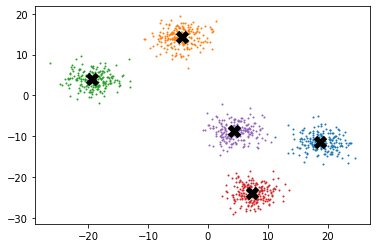

In [303]:
plot_data(centroids, data, n_samples)

### Mean Shift

In [304]:
import math

In [305]:
def gaussian(d, bw): 
    return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [306]:
def plot_func(f):
    x = torch.linspace(0, 10, 100)
    plt.plot(x, f(x))

In [307]:
from functools import partial

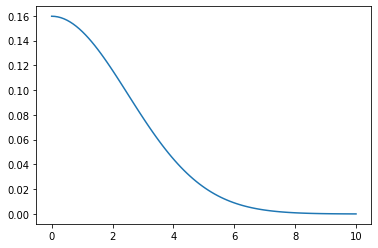

In [308]:
plot_func(partial(gaussian, bw=2.5))

In [309]:
X= data.clone()
x = X[0]
x

tensor([ 17.684, -11.786])

In [310]:
x-X

tensor([[ 0.000,  0.000],
        [ 3.489, -3.649],
        [ 1.217, -0.532],
        ...,
        [15.359, -9.626],
        [13.479, -4.243],
        [13.636, -3.300]])

In [311]:
dist = (((x-X)**2).sum(1))**0.5
dist[:5], dist[-5:]

(tensor([0.000, 5.048, 1.328, 1.591, 4.820]),
 tensor([13.533,  9.440, 18.126, 14.131, 14.029]))

In [312]:
weight = gaussian(dist, 2.5)
weight[:5], weight[-5:]

(tensor([0.160, 0.021, 0.139, 0.130, 0.025]),
 tensor([    0.000,     0.000,     0.000,     0.000,     0.000]))

In [313]:
weight.shape, X.shape, weight[:,None].shape

(torch.Size([1000]), torch.Size([1000, 2]), torch.Size([1000, 1]))

In [314]:
weight[:,None]*X

tensor([[     2.822,     -1.881],
        [     0.295,     -0.169],
        [     2.282,     -1.559],
        ...,
        [     0.000,     -0.000],
        [     0.000,     -0.000],
        [     0.000,     -0.000]])

In [315]:
def one_update(X):
    for i, x in enumerate(X):
        dist = (((x-X)**2).sum(1))**0.5
        weight = gaussian(dist, 2.5)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [316]:
def meanshift(data):
    X = data.clone()
    for i in range(5):
        one_update(X)
    return X

In [317]:
%time X=meanshift(data)

CPU times: user 503 ms, sys: 0 ns, total: 503 ms
Wall time: 513 ms


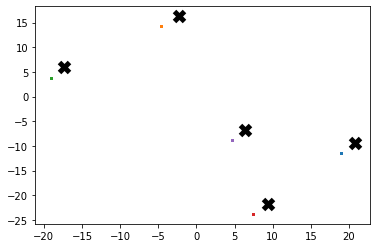

In [318]:
plot_data(centroids+2, X, n_samples)